In [1]:
import os, glob
from smart_open import smart_open
from gensim.utils import tokenize as _tokenize
from collections import namedtuple, OrderedDict
import re

dataDir = 'aclImdb'

if not os.path.isdir(dataDir):
    raise Exception('Download Data')

folders = ['train', 'test']
sentiments = OrderedDict({'pos': 1, 'neg': -1, 'unsup': 0})

SentimentDocument = namedtuple('SentimentDocument', 'words tags movie_id rating sentiment')

filename_matcher = re.compile(r'(.*)_(.*).txt')

# return generator of lines for a file
def read(fn):
    with smart_open(fn, 'rb') as f:
        # for l in f:
        #    yield l.decode('utf-8')
        return f.read().decode('utf-8')

def getIDandRating(fn):
    p = filename_matcher.match(os.path.basename(fn))
    return int(p.group(1)), int(p.group(2))

# Generator of generators
def flatMap(ls, func=lambda x: x):
    return (func(i) for l in ls for i in l)

# generator of lines -> generator of tokens
def tokenize(line):
    return (token for token in _tokenize(line, lowercase=True, deacc=True))

urlmatcher = re.compile(r"http://www.imdb.com/title/(.*)/usercomments")

def genFiles():
    for d in folders:
        for s, si in sentiments.items():
            if not os.path.isdir("{}/{}/{}".format(dataDir, d, s)): continue
            filelist = glob.glob("{}/{}/{}/*.txt".format(dataDir, d, s))
            fileSet = [(*getIDandRating(fn), fn) for fn in filelist]
            fileSet.sort(key=lambda t: t[0])
            with smart_open("{}/{}/urls_{}.txt".format(dataDir, d, s), 'r') as urlfile:
                movie_ids = (urlmatcher.match(url).group(1) for url in urlfile)
                for movie_id, (fid, rating, f) in zip(movie_ids, fileSet):
                    yield si, movie_id, rating, f

# gen of gen of tokens
tokenLists = ((s, movie_id, rating, tokenize(read(f))) for s, movie_id, rating, f in genFiles())

In [2]:
%%time

if not os.path.isfile('all_data.txt'):
    with smart_open('all_data.txt', 'wb') as f:
        for s, movie_id, rating, tl in tokenLists:
            f.write('{} {} {} {}\n'.format(s, movie_id, rating, ' '.join(tl)).encode('utf-8'))
else:
    print('data file exists')

data file exists
CPU times: user 1.67 ms, sys: 163 µs, total: 1.84 ms
Wall time: 87 µs


In [3]:
%%time
# from random import shuffle

# docs
allDocs = []
with smart_open('all_data.txt', 'rb') as f:
    for i, line in enumerate(f):
        l = line.decode('utf-8').split()
        allDocs.append(SentimentDocument(l[3:], [i], l[1], int(l[2]), int(l[0])))
        
# shuffle(allDocs)

CPU times: user 2.09 s, sys: 277 ms, total: 2.36 s
Wall time: 2.18 s


In [4]:
import multiprocessing

cpuCount = multiprocessing.cpu_count()

**Models**
Fix vector size to 100, and min_count (cutoff) to 3 (as per the Pang&Lee). 

For each model, ID string = "model:window_size:epoch", and store the model to a file.

In [5]:
from gensim.models.doc2vec import Doc2Vec
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

archs = ['dbow', 'dmm', 'dmc', 'dbow+dmm', 'dbow+dmc']
ws = [8, 12]
vs = 100
mc = 3
s = 0
es = [10, 20]

readModels = OrderedDict()

def getIDstr(arch, w, e):
    return "{}:{}:{}".format(arch, w, e)

def genIDstrs():
    for w in ws:
        for e in es:
            for arch in archs:
                yield getIDstr(arch, w, e)

def createModel(idstr):
    ids = idstr.split(':')
    w = int(ids[1])
    e = int(ids[2])
    if ids[0] == 'dbow':
        return Doc2Vec(dm=0, window=w, vector_size=vs, min_count=mc, sample=s, epochs=e, workers=cpuCount)
    elif ids[0] == 'dmm':
        return Doc2Vec(dm=1, window=w, vector_size=vs, min_count=mc, sample=s, epochs=e, alpha=0.05, comment='alpha=0.05', workers=cpuCount)
    elif ids[0] == 'dmc':
        return Doc2Vec(dm=1, dm_concat=1, window=w//2, vector_size=vs, sample=s, min_count=mc, epochs=e, workers=cpuCount)
    else:
        raise Exception('arch does not exist')

def createConcatModel(idstr):
    ids = idstr.split(':')
    w = int(ids[1])
    e = int(ids[2])
    return ConcatenatedDoc2Vec([getModel(getIDstr(arch, w, e)) for arch in ids[0].split('+')])

def getModel(idstr):
    if idstr in readModels:
        return readModels[idstr]
    f = os.path.abspath('models/{}'.format(idstr))
    if os.path.isfile(f):
        print('loading model {} from file'.format(idstr))
        model = Doc2Vec.load(f)
    elif '+' in idstr:
        print('creating concat model {}'.format(idstr))
        model = createConcatModel(idstr)
    else:     
        print('creating {}'.format(idstr))
        model = createModel(idstr)
        model.build_vocab(allDocs)
        print('training {}'.format(idstr))
        model.train(allDocs, total_examples=len(allDocs), epochs=model.epochs)
        print('saving {}'.format(idstr))
        model.save(f)
    readModels[idstr] = model
    return model

In [6]:
%%time

models = [getModel(idstr) for idstr in genIDstrs()]

creating dbow:8:10
training dbow:8:10
saving dbow:8:10
creating dmm:8:10
training dmm:8:10
saving dmm:8:10
creating dmc:8:10
training dmc:8:10
saving dmc:8:10
creating concat model dbow+dmm:8:10
creating concat model dbow+dmc:8:10
creating dbow:8:20
training dbow:8:20
saving dbow:8:20
creating dmm:8:20
training dmm:8:20
saving dmm:8:20
creating dmc:8:20
training dmc:8:20
saving dmc:8:20
creating concat model dbow+dmm:8:20
creating concat model dbow+dmc:8:20
creating dbow:12:10
training dbow:12:10
saving dbow:12:10
creating dmm:12:10
training dmm:12:10
saving dmm:12:10
creating dmc:12:10
training dmc:12:10
saving dmc:12:10
creating concat model dbow+dmm:12:10
creating concat model dbow+dmc:12:10
creating dbow:12:20
training dbow:12:20
saving dbow:12:20
creating dmm:12:20
training dmm:12:20
saving dmm:12:20
creating dmc:12:20
training dmc:12:20
saving dmc:12:20
creating concat model dbow+dmm:12:20
creating concat model dbow+dmc:12:20
CPU times: user 5h 5min 47s, sys: 1min 51s, total: 5h 

In [7]:
from itertools import islice

# Get first 2000
posDocs = (doc for doc in allDocs if doc.sentiment == 1)
negDocs = (doc for doc in allDocs if doc.sentiment == -1)

def splitH(docs):
    folds = tuple(docs[i::10] for i in range(10))
    return folds[0], [doc for docs in folds[1:] for doc in docs]

posVC, posRest = splitH(list(islice(posDocs, 1000)))
negVC, negRest = splitH(list(islice(negDocs, 1000)))

vc = posVC + negVC
rest = posRest + negRest

def splitV(docs):
    return [doc.words for doc in docs], [doc.sentiment for doc in docs]

# Permutation Testing

In [8]:
def yesOrNo(actual, results):
    assert len(actual) == len(results)
    return [1 if actual[i] == results[i] else 0 for i in range(len(actual))]

def permTest(xs, ys, r):
    n = len(xs)
    diff = np.abs(np.mean(xs) - np.mean(ys))
    k = 1
    for i in range(r):
        rands = np.random.rand(n)
        gx, gy = zip(*tuple(((x, y) if rand >= 0.5 else (y, x)) for rand, x, y in zip(rands, xs, ys)))
        k += diff <= np.abs(np.mean(gx) - np.mean(gy))
    return k / (r + 1)

In [18]:
%%time

import numpy as np
from svm import Doc2VecSVM

initialSVMs = OrderedDict((name, Doc2VecSVM(getModel(name))) for name in genIDstrs())
results = dict()

rest_X, rest_y = splitV(rest)
vc_X, vc_y = splitV(vc)

for name, svm in initialSVMs.items():
    print('Training svm for {}'.format(name))
    svm.fit(rest_X, rest_y)
    print('Evaluating svm for {}'.format(name))
    pred = svm.predict(vc_X)
    result = yesOrNo(vc_y, pred)
    results[name] = result
    print('Score: {}'.format(np.mean(result)))

Training svm for dbow:8:10
Evaluating svm for dbow:8:10
Score: 0.875
Training svm for dmm:8:10
Evaluating svm for dmm:8:10
Score: 0.83
Training svm for dmc:8:10
Evaluating svm for dmc:8:10
Score: 0.645
Training svm for dbow+dmm:8:10
Evaluating svm for dbow+dmm:8:10
Score: 0.895
Training svm for dbow+dmc:8:10
Evaluating svm for dbow+dmc:8:10
Score: 0.82
Training svm for dbow:8:20
Evaluating svm for dbow:8:20
Score: 0.875
Training svm for dmm:8:20
Evaluating svm for dmm:8:20
Score: 0.815
Training svm for dmc:8:20
Evaluating svm for dmc:8:20
Score: 0.71
Training svm for dbow+dmm:8:20
Evaluating svm for dbow+dmm:8:20
Score: 0.865
Training svm for dbow+dmc:8:20
Evaluating svm for dbow+dmc:8:20
Score: 0.815
Training svm for dbow:12:10
Evaluating svm for dbow:12:10
Score: 0.88
Training svm for dmm:12:10
Evaluating svm for dmm:12:10
Score: 0.86
Training svm for dmc:12:10
Evaluating svm for dmc:12:10
Score: 0.6
Training svm for dbow+dmm:12:10
Evaluating svm for dbow+dmm:12:10
Score: 0.855
Train

In [19]:
basecase = results['dbow:12:20']

for name in ['dbow:8:20', 'dbow:12:10', 'dmm:12:20', 'dmc:12:20', 'dbow+dmm:12:20', 'dbow+dmc:12:20']:
    p = permTest(basecase, results[name], 5000)
    print('{} {}'.format(name, p))

dbow:8:20 1.0
dbow:12:10 0.8274345130973805
dmm:12:20 0.5936812637472505
dmc:12:20 0.0001999600079984003
dbow+dmm:12:20 0.5338932213557288
dbow+dmc:12:20 0.5016996600679864


# Step 2

# Cross Validation

In [20]:
from bag import BagOfFrequency
from svm import NaiveSVM
from sklearn.metrics import accuracy_score


def runSVM(svm, train_X, train_y, test_X):
    svm.fit(train_X, train_y)
    return svm.predict(test_X)


# Cross Validation

newPredict = []
prevPredict = []
actual = []

folds = tuple(rest[i::10] for i in range(10))

for i in range(10):
    print('Fold {}'.format(i+1))
    test = folds[i]
    train = [doc for j in range(10) for doc in folds[j] if j != i]
    train_X, train_y = splitV(train)
    test_X, test_y = splitV(test)
    
    newSVM = Doc2VecSVM(getModel('dbow:12:20'))
    prevSVM = NaiveSVM(BagOfFrequency, {1}, 3)
    nr = runSVM(newSVM, train_X, train_y, test_X)
    pr = runSVM(prevSVM, train_X, train_y, test_X)
    newPredict.extend(nr)
    prevPredict.extend(pr)
    actual.extend(test_y)
    
newScore = accuracy_score(actual, newPredict)
prevScore = accuracy_score(actual, prevPredict)

print(newScore)
print(prevScore)

new = yesOrNo(actual, newPredict)
prev = yesOrNo(actual, prevPredict)

p = permTest(new, prev, 5000)
print(p)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10
0.8738888888888889
0.7883333333333333
0.0001999600079984003


# Good Science

# Visualisation

In [ ]:
# # Get TSVs for projector.tensorflow.org
# 
# model = getModel('dbow+dmm:10:20')
# docstrs = (doc2str(model, doc) for doc in allDocs if doc.rating != 0)
# 
# lookup = dict()
# cnt = 0
# with smart_open('vecstr.tsv', 'w') as v:
#     with smart_open('metastr.tsv', 'w') as m:
#         m.write('tags\tmovie_id\trating\tsentiment\n')
#         for doc in allDocs:
#             if doc.rating != 0:
#                 if doc.movie_id not in lookup:
#                     lookup[doc.movie_id] = cnt
#                     cnt += 1
#                 v.write("\t".join(str(vec) for vec in model.docvecs[doc.tags[0]]))
#                 v.write('\n')
#                 m.write('{}\t{}\t{}\t{}\n'.format(doc.tags[0], lookup[doc.movie_id], doc.rating, doc.sentiment))

## Comparing documents of the same rating

In [ ]:
##### Filter documents by same sentiment and movie_id
# from itertools import groupby

# testDocs = ((k, g) for k, g in groupby(allDocs, lambda doc: doc.movie_id))
# testDocs = ((mid, k, list(g)) for mid, docs in testDocs for k, g in groupby(docs, lambda doc: doc.rating))

# model = getModel('dbow:10:20')
# docvecs = model.docvecs
# for mid, rating, docs in testDocs:
#    tags = [doc.tags[0] for doc in docs]
#    arr = np.fromiter((docvecs.similarity(t1, t2) for t1 in tags for t2 in tags if t1 != t2), float)
#    if len(arr) > 0:
#        avg = np.average(arr)
#        print(avg)
        

In [ ]:
#testDocs: movie_id -> rating -> docs
#easier to read
#findDocs = dict(((mid, rating), docs) for mid, mdocs in testDocs.items() for rating, docs in mdocs.items() if len(docs) > 10)
#(mid, rating), checkDocs = findDocs.popitem()
#print(mid, rating)
#tags = [doc.tags[0] for doc in checkDocs]
#print(" ".join(str(tag-(75000+12500)) for tag in tags))


In [ ]:
# load genre data
# movie_ids = frozenset(doc.movie_id for doc in allDocs)
# genres = dict()
# genre_count = 0

# with smart_open('genres.tsv', 'w') as w:
#    with smart_open('title.basics.tsv', 'r') as f:
#        fields = f.readline()
#        for line in f:
#            items = line.split('\t')
#            movie_id = items[0]
#            if movie_id in movie_ids:
#                w.write('{}\t{}'.format(movie_id, items[-1]))

In [ ]:
#genres = dict()
#with smart_open('genres.tsv', 'r') as f:
#    for line in f:
#        items = line.rstrip().split('\t')
#        movie_id = items[0]
#        genres[movie_id] = set(items[1].split(','))

In [ ]:
#model = getModel('dbow:10:20')
#dv = model.docvecs

#classifiedDocs = [doc for doc in allDocs if doc.sentiment != 0]
#for doc in classifiedDocs:
#    same_movie = [d for d in classifiedDocs if d.movie_id == doc.movie_id]
#    ds = [(dv.distance(doc.tags[0], d2.tags[0]), d2) for d2 in classifiedDocs]
#    ds.sort(key=lambda p: p[0])
#    five = ds[1:int(len(ds)/2)] # 5% without itself
#    joint = [d for dist, d in five if d.sentiment == doc.sentiment]# if d.movie_id in genres and len(gs.intersection(genres[d.movie_id])) > 0
#    print(len(joint) / len(five))
    

In [29]:
from random import shuffle
import gzip

def getAmazonReviews(filename):
    with gzip.open(filename, 'rt') as g:
        for l in g:
            obj = eval(l)
            if obj['overall'] >= 3.5:
                sentiment = 1
            elif obj['overall'] <= 2:
                sentiment = -1
            else:
                continue
            yield sentiment, list(tokenize(obj['reviewText']))

def getBalancedSet(stream):
    pos = list(islice(((s, d) for s, d in stream if s == 1), 100))
    neg = list(islice(((s, d) for s, d in stream if s == -1), 100))
    total = pos + neg
    shuffle(total)
    return total

amazon = dict()
amazon['home'] = getBalancedSet(getAmazonReviews('amazon/reviews.home.json.gz'))
amazon['auto'] = getBalancedSet(getAmazonReviews('amazon/reviews.auto.json.gz'))
amazon['movie'] = getBalancedSet(getAmazonReviews('amazon/reviews.movie.json.gz'))
amazon['video'] = getBalancedSet(getAmazonReviews('amazon/reviews.instantvideo.json.gz'))
amazon['music'] = getBalancedSet(getAmazonReviews('amazon/reviews.digitalmusic.json.gz'))
amazon['clothings'] = getBalancedSet(getAmazonReviews('amazon/reviews.clothings.json.gz'))
amazon['health'] = getBalancedSet(getAmazonReviews('amazon/reviews.health.json.gz'))
amazon['sports'] = getBalancedSet(getAmazonReviews('amazon/reviews.sports.json.gz'))
amazon['office'] = getBalancedSet(getAmazonReviews('amazon/reviews.office.json.gz'))
amazon['garden'] = getBalancedSet(getAmazonReviews('amazon/reviews.garden.json.gz'))

In [45]:
# Cross Validation

train2 = vc + rest
train2_X, train2_y = splitV(train2)

newSVM = Doc2VecSVM(getModel('dbow:12:20'))
prevSVM = NaiveSVM(BagOfFrequency, {1}, 3)
newSVM.fit(train2_X, train2_y)
prevSVM.fit(train2_X, train2_y)

def testAmazon(reviewList):
    rev_y, rev_X = zip(*reviewList)
    newP = newSVM.predict(rev_X)
    prevP = prevSVM.predict(rev_X)
    newR = yesOrNo(newP, rev_y)
    prevR = yesOrNo(prevP, rev_y)
    newA = np.mean(newR)
    prevA = np.mean(prevR)
    p = permTest(newR, prevR, 5000)
    print('doc2vec accuracy: {}'.format(newA))
    print('naive accuracy: {}'.format(prevA))
    return newA, prevA, p

ptypes = ['movie', 'video', 'music', 'clothings', 'garden', 'home', 'office', 'sports']

docResults = dict()
naiveResults = dict()
pResults = dict()

for pt in ptypes:
    docResults[pt], naiveResults[pt], pResults[pt] = testAmazon(amazon[pt])

doc2vec accuracy: 0.855
naive accuracy: 0.77
doc2vec accuracy: 0.835
naive accuracy: 0.76
doc2vec accuracy: 0.835
naive accuracy: 0.685
doc2vec accuracy: 0.695
naive accuracy: 0.69
doc2vec accuracy: 0.65
naive accuracy: 0.64
doc2vec accuracy: 0.785
naive accuracy: 0.665
doc2vec accuracy: 0.76
naive accuracy: 0.655
doc2vec accuracy: 0.65
naive accuracy: 0.59


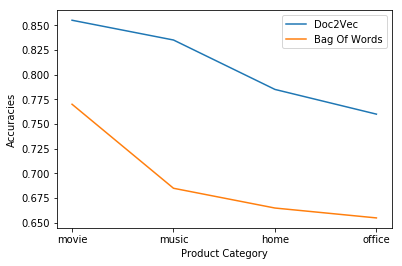

In [67]:
%matplotlib inline

import matplotlib.pyplot as plt

docd = OrderedDict(sorted(docResults.items(), key=lambda p: p[1], reverse=True))
naived = OrderedDict(sorted(naiveResults.items(), key=lambda p: p[1], reverse=True))

x = [k for k in docd.keys() if pResults[k] <= 0.05]
doc_y = [docd[k] for k in doc_x]
naive_y = [naived[k] for k in doc_x]
p_y = [pResults[k] for k in doc_x]
plt.xlabel('Product Category')
plt.ylabel('Accuracies')
doc_l, = plt.plot(x, doc_y)
naive_l, = plt.plot(x, naive_y)
plt.legend([doc_l, naive_l], ['Doc2Vec', 'Bag Of Words'])
plt.show()


In [66]:
for i in docd.keys():
    print("{} & {:3.1f}\% & {:3.1f}\% & {:5.4f} \\\\".format(i, docd[i]*100, naived[i]*100, pResults[i]))

movie & 85.5\% & 77.0\% & 0.0126 \\
video & 83.5\% & 76.0\% & 0.0512 \\
music & 83.5\% & 68.5\% & 0.0008 \\
home & 78.5\% & 66.5\% & 0.0030 \\
office & 76.0\% & 65.5\% & 0.0150 \\
clothings & 69.5\% & 69.0\% & 1.0000 \\
garden & 65.0\% & 64.0\% & 0.9004 \\
sports & 65.0\% & 59.0\% & 0.2346 \\
